In [1]:
import pandas as pd
import numpy as np

#Tensor flow
from tensorflow.keras.preprocessing.text import text_to_word_sequence
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers, Sequential, layers
from tensorflow.keras.layers import Embedding, LSTM, Dense
from tensorflow.keras.callbacks import EarlyStopping
import keras
import matplotlib.pyplot  as plt

2024-08-15 09:49:21.367901: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-08-15 09:49:21.367971: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-08-15 09:49:21.402794: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-08-15 09:49:21.489536: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-08-15 09:49:22.791493: W tensorflow/compiler/tf2

In [2]:
file_submission = 'data/sample_submission.csv'
file_train_data = 'data/train.csv'
file_test_data = 'data/test.csv'
df_sub = pd.read_csv(file_submission)
df_train = pd.read_csv(file_train_data)
df_test = pd.read_csv(file_test_data)

In [3]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7613 entries, 0 to 7612
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   id        7613 non-null   int64 
 1   keyword   7552 non-null   object
 2   location  5080 non-null   object
 3   text      7613 non-null   object
 4   target    7613 non-null   int64 
dtypes: int64(2), object(3)
memory usage: 297.5+ KB


In [4]:
# Cut percentage of train vs test
percentage_cut = 20
cut_test = len(df_train) * 20 // 100
cut_train = len(df_train) - cut_test

In [5]:
# Cut percentage of train vs test

X = df_train['text']
X_pred = df_test['text']
tokenizer = Tokenizer()

tokenizer.fit_on_texts(X)

X_train_token = tokenizer.texts_to_sequences(X)
X_pred_token = tokenizer.texts_to_sequences(X_pred)

In [6]:
def percentage_loss(token_words, padding_max)->str:
    """
        Test the percentage loss after padding
        Example: percentage_loss(X_token, 25) => 'After padding loss: 1.22%'
    """
    
    get_over_lenght = len([tok for tok in token_words if len(tok) >= padding_max])
    percent = get_over_lenght * 100 / len(token_words)
    
    return f'After padding loss: {percent:.2f}%'

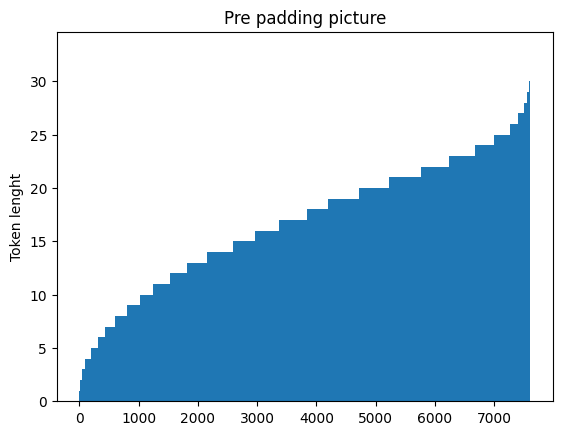

In [7]:
# Check the relevance of padding trading off performance

X_sort = sorted(X_train_token, key=lambda x: len(x))
plt.bar(x= np.arange(1, len(X_sort) + 1), height=[len(num) for num in X_sort], width=1)
plt.title('Pre padding picture')
plt.ylabel('Token lenght')
plt.show();

In [8]:
# Padding words
X_train_pad = pad_sequences(X_train_token, dtype='float32', padding='pre', maxlen=30)
X_pred_pad = pad_sequences(X_pred_token, dtype='float32', padding='pre')

X_train_pad = X_train_pad[:cut_train]
X_test_pad = X_train_pad[-cut_test:]

y_train = df_train['target'][:cut_train]
y_test = df_train['target'][-cut_test:]

In [9]:
# Initialize model and define vocabulary size
vocab_size = len(tokenizer.word_index)

def initialize_model():

    model = Sequential()
    
    model.add(layers.Embedding(
        input_dim= vocab_size + 1,
        input_length= 30, 
        output_dim = 1, 
        mask_zero = True
    ))
    model.add(LSTM(64))
    model.add(Dense(1, activation='sigmoid'))

    
    optimizer = keras.optimizers.Adam(learning_rate=0.01)
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    
    return model

In [10]:
model = initialize_model()
model.summary()

2024-08-15 09:49:34.568725: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-15 09:49:34.718953: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-15 09:49:34.719006: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-15 09:49:34.722346: I external/local_xla/xla/stream_executor/cuda/cuda_executor.cc:887] could not open file to read NUMA node: /sys/bus/pci/devices/0000:26:00.0/numa_node
Your kernel may have been built without NUMA support.
2024-08-15 09:49:34.722401: I external/local_xla/xla/stream_executor

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 30, 1)             22701     
                                                                 
 lstm (LSTM)                 (None, 64)                16896     
                                                                 
 dense (Dense)               (None, 1)                 65        
                                                                 
Total params: 39662 (154.93 KB)
Trainable params: 39662 (154.93 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [11]:
es = EarlyStopping(patience=4, restore_best_weights=True)

history = model.fit(
    X_train_pad, 
    y_train, 
    batch_size=128, 
    epochs=20, 
    validation_data=(X_test_pad, y_test),
    callbacks = [es])

Epoch 1/20


2024-08-15 09:49:38.403102: W tensorflow/core/common_runtime/type_inference.cc:339] Type inference failed. This indicates an invalid graph that escaped type checking. Error message: INVALID_ARGUMENT: expected compatible input types, but input 1:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_INT32
    }
  }
}
 is neither a subtype nor a supertype of the combined inputs preceding it:
type_id: TFT_OPTIONAL
args {
  type_id: TFT_PRODUCT
  args {
    type_id: TFT_TENSOR
    args {
      type_id: TFT_FLOAT
    }
  }
}

	for Tuple type infernce function 0
	while inferring type of node 'cond_36/output/_23'
2024-08-15 09:49:40.160345: I external/local_xla/xla/service/service.cc:168] XLA service 0x7fb27db8d2e0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
2024-08-15 09:49:40.160400: I external/local_xla/xla/service/service.cc:176]   StreamExecutor device (0): NVIDIA GeForce RTX 3070, Co

48/48 [==============================] - 15s 231ms/step - loss: 0.6234 - accuracy: 0.6538 - val_loss: 0.9297 - val_accuracy: 0.5473
Epoch 2/20
48/48 [==============================] - 8s 175ms/step - loss: 0.3495 - accuracy: 0.8632 - val_loss: 1.0559 - val_accuracy: 0.5657
Epoch 3/20
48/48 [==============================] - 8s 172ms/step - loss: 0.1686 - accuracy: 0.9384 - val_loss: 2.1643 - val_accuracy: 0.5611
Epoch 4/20
48/48 [==============================] - 8s 175ms/step - loss: 0.0804 - accuracy: 0.9731 - val_loss: 2.8772 - val_accuracy: 0.5670
Epoch 5/20
48/48 [==============================] - 8s 158ms/step - loss: 0.0445 - accuracy: 0.9883 - val_loss: 2.6799 - val_accuracy: 0.5723


In [12]:
pred_res = model.predict(X_pred_pad)

102/102 [==============================] - 4s 30ms/step


<BarContainer object of 3263 artists>

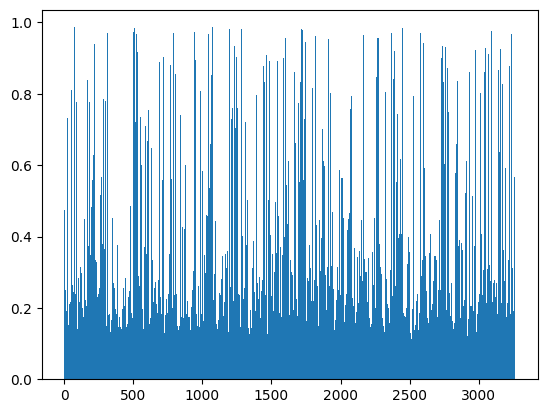

In [13]:
plt.bar(x= np.arange(1, len(pred_res) + 1), height= [float(res) for res in pred_res], width=1)

In [14]:
map_res = [1 if x > 0.5 else 0 for x in pred_res ]

In [23]:
df_sub

,id,target
0,0,0
1,2,0
2,3,0
3,9,0
4,11,0
...,...,...
3258,10861,0
3259,10865,0
3260,10868,0
3261,10874,0


In [42]:
df_test['target'] = map_res
df_submit = df_test[['id','target']]
df_submit.to_csv('data/submit_15_08_24.csv', index= False)

In [43]:
pd.read_csv('data/submit_15_08_24.csv')

,id,target
0,0,0
1,2,0
2,3,1
3,9,0
4,11,1
...,...,...
3258,10861,1
3259,10865,1
3260,10868,1
3261,10874,1


In [ ]:
# Score was 0.7744